##Group 4 - Forecasting and Clusting Electrice Vehicle Adoption in Ontario

**Data Pre-Processing**

Data cleaning of electric vehicle (EV) adoption across Ontario between Q1 2024 to Q1 2025. The data has been normalized and able to handle any missing values.

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import sys
import subprocess

df = pd.read_csv('Q2-2023 - Q1-2025.csv')   # For local environments
df = df[df['FSA'].str.startswith(('K', 'L', 'M', 'N', 'P'))].reset_index(drop=True)
time_series = df.groupby('Quarter')['TotalEV'].sum().reset_index()

def quarter_to_numeric(q):
    quarter, year = q.split('-')
    quarters_map = {'Q1': 0.0, 'Q2': 0.25, 'Q3': 0.5, 'Q4': 0.75}
    return float(year) + quarters_map[quarter]

time_series['TimeIndex'] = time_series['Quarter'].apply(quarter_to_numeric)
time_series = time_series.sort_values('TimeIndex')
series_values = time_series['TotalEV'].values.reshape(-1, 1)

# --- Normalize the series ---
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series_values)

# --- Create sequences for the LSTM ---
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:(i + n_steps_in)])
        y.append(data[(i + n_steps_in):(i + n_steps_in + n_steps_out)])
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 2, 1  # Adjust as needed
X, y = create_sequences(series_scaled, n_steps_in, n_steps_out)
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape((y.shape[0], ))

# --- Fixed number of test samples ---
n_test = 5
if len(X) <= n_test:
    raise ValueError(f"Not enough samples ({len(X)}) to allocate {n_test} test samples.")
split_idx = len(X) - n_test
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

# --- Model builder with Input() layer ---
def create_lstm_model(units=50, dropout=0.0, optimizer='adam', activation='tanh'):
    model = Sequential()
    model.add(Input(shape=(n_steps_in, 1)))
    model.add(LSTM(units, activation=activation))
    if dropout > 0.0:
        model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# --- SciKeras KerasRegressor setup ---
keras_reg = KerasRegressor(
    model=create_lstm_model,
    units=50,
    dropout=0.0,
    optimizer='adam',
    activation='tanh',
    epochs=10,                # <---- Set low epoch count here
    batch_size=8,
    verbose=1,
    callbacks=[EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)]
)

param_grid = {
    'units': [20, 50],
    'dropout': [0.0, 0.1],
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['tanh', 'relu'],
    'epochs': [30],
    'batch_size': [8, 16]
}

# --- Grid search or single model if data is tiny ---
n_train_samples = X_train.shape[0]
if n_train_samples < 3:
    print(f"Only {n_train_samples} train samples: fitting single model without CV.")
    first_params = {k: v[0] if isinstance(v, list) else v for k, v in param_grid.items()}
    keras_reg.set_params(**first_params)
    keras_reg.fit(X_train, y_train)
    best_model = keras_reg
else:
    n_splits = min(3, n_train_samples - 1)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    grid = GridSearchCV(
        estimator=keras_reg,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=1
    )
    grid.fit(X_train, y_train)
    print(f"Best CV Score: {grid.best_score_:.4f}")
    print(f"Best Params: {grid.best_params_}")
    best_model = grid.best_estimator_

C:\Users\mundl\anaconda3\envs\DS3_MachineLearning\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Train samples: 1, Test samples: 5
Only 1 train samples: fitting single model without CV.
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0793
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0772
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0752
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0731
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0711
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0691
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0672
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0652
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0633
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0614
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0595
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0576
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0557
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0539
Epoch 15/30


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Test R²: -3.379
Test RMSE: 47090.57
Test MAE: 44052.77


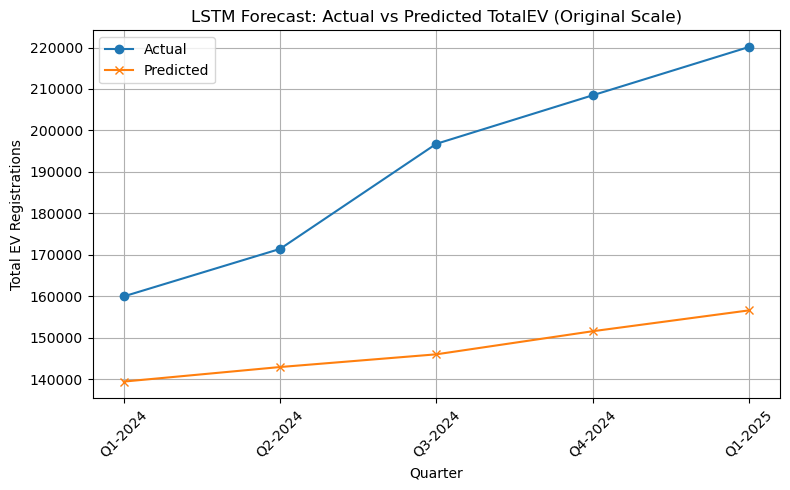

In [ ]:
# --- Predict and evaluate on original scale ---
y_pred = best_model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
if len(y_test_inv) >= 2:
    r2 = r2_score(y_test_inv, y_pred_inv)
    print(f"Test R²: {r2:.3f}")
else:
    print("R² is not well-defined with less than two test samples; skipping R².")

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

quarters = list(time_series['Quarter'])
quarters_test = quarters[len(quarters) - len(y_test):]

# --- Plot and save figure ---
plt.figure(figsize=(8, 5))
plt.plot(range(len(y_test_inv)), y_test_inv, label='Actual', marker='o')
plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Predicted', marker='x')
plt.title('LSTM Forecast: Actual vs Predicted TotalEV (Original Scale)')
plt.xlabel('Quarter')
plt.ylabel('Total EV Registrations')
plt.xticks(ticks=range(len(quarters_test)), labels=quarters_test, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Figures/lstm_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

LSTM is vastly underperforming the mean-baseline on current test window, as shown by very negative R² and large RMSE/MAE.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

series = time_series['TotalEV'].values
quarters = time_series['Quarter'].values

n_test = 5
train, test = series[:-n_test], series[-n_test:]

# Naïve forecast: "last value" from train is used for all test points
y_pred = np.full_like(test, fill_value=train[-1], dtype=np.float64)

rmse = np.sqrt(mean_squared_error(test, y_pred))
mae = mean_absolute_error(test, y_pred)
r2 = r2_score(test, y_pred) if len(test) >= 2 else None

print(f"Naïve Last Value - Test RMSE: {rmse:.2f}")
print(f"Naïve Last Value - Test MAE: {mae:.2f}")
if r2 is not None:
    print(f"Naïve Last Value - Test R²: {r2:.3f}")
else:
    print("Naïve Last Value - R² not defined (less than 2 test points)")


Naïve Last Value - Test RMSE: 46337.89
Naïve Last Value - Test MAE: 40506.60
Naïve Last Value - Test R²: -3.240


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

n_test = 5
train, test = series[:-n_test], series[-n_test:]

# Fit ARIMA. With short series, use (1,0,0) or (0,1,0) to avoid overfitting
model = ARIMA(train, order=(1,0,0))  # AR(1) example, adjust order as needed
model_fit = model.fit()

# Forecast the next n_test points
forecast = model_fit.forecast(steps=n_test)
y_pred = forecast

rmse = np.sqrt(mean_squared_error(test, y_pred))
mae = mean_absolute_error(test, y_pred)
r2 = r2_score(test, y_pred) if len(test) >= 2 else None

print(f"ARIMA - Test RMSE: {rmse:.2f}")
print(f"ARIMA - Test MAE: {mae:.2f}")
if r2 is not None:
    print(f"ARIMA - Test R²: {r2:.3f}")
else:
    print("ARIMA - R² not defined (less than 2 test points)")


ARIMA - Test RMSE: 59616.37
ARIMA - Test MAE: 55209.91
ARIMA - Test R²: -6.018


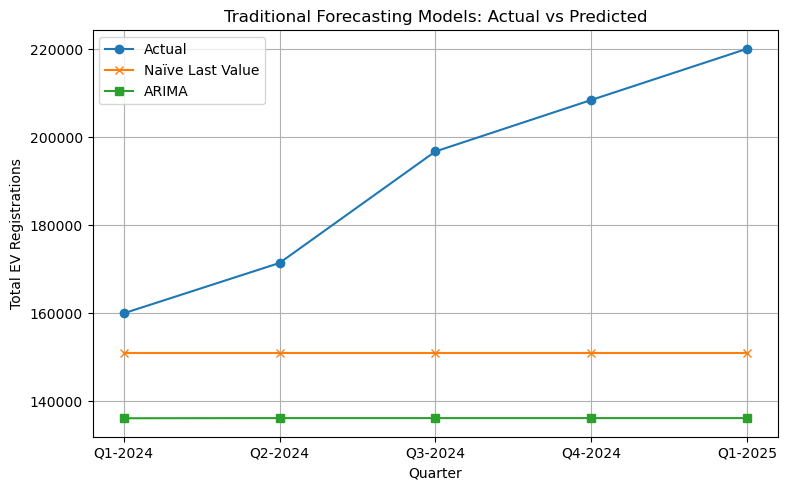

In [ ]:
import matplotlib.pyplot as plt

labels = quarters[-n_test:]
plt.figure(figsize=(8, 5))
plt.plot(labels, test, marker='o', label='Actual')
plt.plot(labels, np.full_like(test, train[-1], dtype=np.float64), marker='x', label='Naïve Last Value')
plt.plot(labels, y_pred, marker='s', label='ARIMA')
plt.title('Traditional Forecasting Models: Actual vs Predicted')
plt.xlabel('Quarter')
plt.ylabel('Total EV Registrations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Figures/lstm_tfm.png', dpi=300, bbox_inches='tight')
plt.show()


Ensemble LSTM model with a traditional model

Data shape: X=(6, 2, 1), y=(6,)
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.1782
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1729
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1676
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1625
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1574
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.1524
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1475
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1427
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1380
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1333
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1288
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1242
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1198
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1154
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1111
1/1

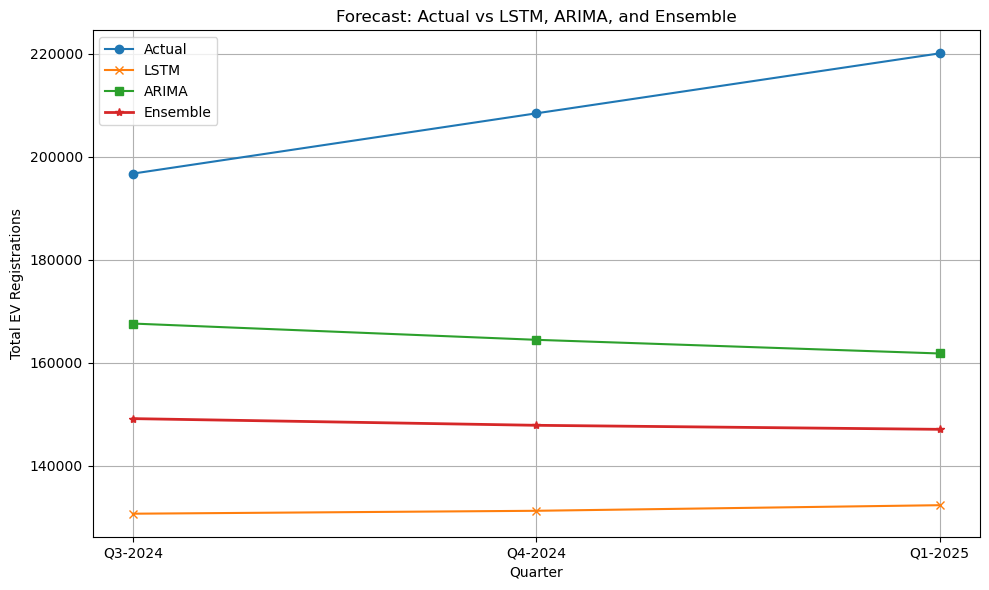

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import sys
import subprocess

df_ev = pd.read_csv('Q2-2023 - Q1-2025.csv')
df_ev = df_ev[df_ev['FSA'].str.startswith(('K', 'L', 'M', 'N', 'P'))].reset_index(drop=True)
ev_series = df_ev.groupby('Quarter')['TotalEV'].sum().reset_index()

# Function to convert quarter string to numeric for sorting
def quarter_to_numeric(q):
    quarter, year = q.split('-')
    quarters_map = {'Q1': 0.0, 'Q2': 0.25, 'Q3': 0.5, 'Q4': 0.75}
    return float(year) + quarters_map[quarter]

# Add TimeIndex for sorting
ev_series['TimeIndex'] = ev_series['Quarter'].apply(quarter_to_numeric)
ev_series = ev_series.sort_values('TimeIndex').reset_index(drop=True)

# Use only EV registrations as feature (univariate time series)
target = ev_series['TotalEV'].values.reshape(-1, 1)

# -------------------------
# 2. Normalize target only
# -------------------------

scaler_target = MinMaxScaler()
target_scaled = scaler_target.fit_transform(target)

# -------------------------
# 3. Create sequences for LSTM (univariate)
# -------------------------

def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:(i + n_steps_in)])
        y.append(data[(i + n_steps_in):(i + n_steps_in + n_steps_out)])
    return np.array(X), np.array(y)

n_steps_in, n_steps_out = 2, 1
X, y = create_sequences(target_scaled, n_steps_in, n_steps_out)
y = y.reshape((y.shape[0], ))

print(f"Data shape: X={X.shape}, y={y.shape}")

# -------------------------
# 4. Train-test split
# -------------------------

n_test_desired = 3
max_n_test = len(X) - 1
n_test = min(n_test_desired, max_n_test)
split_idx = len(X) - n_test

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# -------------------------
# 5. Define and train LSTM model (univariate input shape)
# -------------------------

num_features = 1  # univariate

def create_lstm_model(units=50, dropout=0.0, optimizer='adam', activation='tanh'):
    model = Sequential()
    model.add(Input(shape=(n_steps_in, num_features)))
    model.add(LSTM(units, activation=activation))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

keras_reg = KerasRegressor(
    model=create_lstm_model,
    units=50,
    dropout=0.0,
    optimizer='adam',
    activation='tanh',
    epochs=15,
    batch_size=8,
    verbose=1,
    callbacks=[EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)]
)
keras_reg.fit(X_train, y_train)

# LSTM predictions (inverse scale)
y_pred_lstm_scaled = keras_reg.predict(X_test)
y_pred_lstm = scaler_target.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).flatten()

# -------------------------
# 6. Fit ARIMA on TRAIN data and forecast TEST
# -------------------------

train_target = target[:split_idx + n_steps_in].flatten()

arima_order = (1, 0, 0)  # AR(1), tune if needed
arima_model = ARIMA(train_target, order=arima_order)
arima_fit = arima_model.fit()

arima_forecast = arima_fit.forecast(steps=n_test)
y_pred_arima = arima_forecast.values if hasattr(arima_forecast, 'values') else arima_forecast

# -------------------------
# 7. Prepare true test targets (original scale)
# -------------------------

test_target_orig = target[split_idx + n_steps_in: split_idx + n_steps_in + n_test].flatten()

# -------------------------
# 8. Ensemble predictions by average
# -------------------------

y_pred_ensemble = (y_pred_lstm + y_pred_arima) / 2

# -------------------------
# 9. Evaluate models
# -------------------------

def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred) if len(y_true) >= 2 else None
    print(f"{model_name} - Test RMSE: {rmse:.2f}")
    print(f"{model_name} - Test MAE: {mae:.2f}")
    if r2 is not None:
        print(f"{model_name} - Test R²: {r2:.3f}")
    else:
        print(f"{model_name} - Test R²: Not defined (less than 2 samples)")

evaluate(test_target_orig, y_pred_lstm, "LSTM")
evaluate(test_target_orig, y_pred_arima, "ARIMA")
evaluate(test_target_orig, y_pred_ensemble, "Ensemble")

# -------------------------
# 10. Plot results
# -------------------------

quarters = ev_series['Quarter'].values
test_quarters = quarters[-n_test:]

plt.figure(figsize=(10, 6))
plt.plot(test_quarters, test_target_orig, marker='o', label='Actual')
plt.plot(test_quarters, y_pred_lstm, marker='x', label='LSTM')
plt.plot(test_quarters, y_pred_arima, marker='s', label='ARIMA')
plt.plot(test_quarters, y_pred_ensemble, marker='*', label='Ensemble', linewidth=2)
plt.title('Forecast: Actual vs LSTM, ARIMA, and Ensemble')
plt.xlabel('Quarter')
plt.ylabel('Total EV Registrations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Figures/Ensemble.png', dpi=300, bbox_inches='tight')

plt.show()


The forecasting results reveal significant challenges: the LSTM model shows very large errors with a highly negative R², indicating predictions much worse than simply using the average. The ARIMA model performs better but still fails to reliably outperform naive baselines. The ensemble of both models reduces some errors compared to LSTM alone but does not surpass ARIMA's accuracy.

These outcomes point to limitations in data quantity and quality rather than modeling choices. Insufficient and volatile data, along with a lack of explanatory features, hinder model effectiveness. Improvements require more extensive historical data and richer external variables.

Given the poor performance, simpler models or baselines may provide more reliable forecasts initially. Employing rolling validation can offer better insights into model generalization. Advanced ensembling or weighted model combinations might yield marginal improvements but cannot fully compensate for core data issues.

In summary, current forecasts are unreliable due to data constraints. ARIMA is more stable but inadequate; the ensemble helps moderate errors without exceeding ARIMA performance. Enhancing data quality, simplifying models, and using robust validation are essential next steps.

**Data Cleaning & Feature Engineering**

This was used to calculate quarterly growth rates in Ontario, the BEV/PHEV ratios during these times, and the rolling average of EV registrations, quarterly, in Ontario.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
# file_path = '/content/drive/My Drive/DS3_Machine Learning_Group 4/Data/Q2-2023 - Q1-2025.csv'
# df = pd.read_csv(file_path)

In [ ]:
# df = pd.read_csv('Q2-2023 - Q1-2025.csv')   # For local environments

In [ ]:
df.head(5)

_id  FSA    BEV   PHEV  TotalEV  Quarter
0    1  K0A  752.0  336.0     1088  Q2-2023
1    2  K0B   73.0   58.0      131  Q2-2023
2    3  K0C  163.0  106.0      269  Q2-2023
3    4  K0E  113.0   69.0      182  Q2-2023
4    5  K0G  223.0  103.0      326  Q2-2023

Forward Sortation Area(FSA)

K = Eastern Ontario L = Central Ontario M = Metropolitan Toronto N = Southwestern Ontario P = Northern Ontario

In [ ]:
# Ontario FSA prefixes
ontario_prefixes = ('K', 'L', 'M', 'N', 'P')

# Quarters to keep
quarters = ['Q4-2023', 'Q1-2024', 'Q2-2024', 'Q3-2024', 'Q4-2024', 'Q1-2025']

# Filter for Ontario FSAs and selected quarters
df_ontario = df[
    df['FSA'].str.startswith(ontario_prefixes) &
    df['Quarter'].isin(quarters)
].reset_index(drop=True)

print(df_ontario.head())

   _id  FSA    BEV   PHEV  TotalEV  Quarter
0    1  K0A  959.0  398.0     1357  Q4-2023
1    2  K0B  102.0   60.0      162  Q4-2023
2    3  K0C  208.0  129.0      337  Q4-2023
3    4  K0E  160.0   84.0      244  Q4-2023
4    5  K0G  262.0  118.0      380  Q4-2023


In [ ]:
df_ontario = df_ontario.drop(columns=['_id'])

In [ ]:
df_ontario.head()

FSA    BEV   PHEV  TotalEV  Quarter
0  K0A  959.0  398.0     1357  Q4-2023
1  K0B  102.0   60.0      162  Q4-2023
2  K0C  208.0  129.0      337  Q4-2023
3  K0E  160.0   84.0      244  Q4-2023
4  K0G  262.0  118.0      380  Q4-2023

In [ ]:
df_ontario.tail()

FSA   BEV  PHEV  TotalEV  Quarter
3453  P8A   1.0   NaN        1  Q1-2025
3454  P8N  17.0  17.0       34  Q1-2025
3455  P8T   6.0  12.0       18  Q1-2025
3456  P9A   9.0  14.0       23  Q1-2025
3457  P9N  22.0  23.0       45  Q1-2025

In [ ]:
len(df_ontario)

3458

In [ ]:
df_ontario['Quarter'].unique()

array(['Q4-2023', 'Q1-2024', 'Q2-2024', 'Q3-2024', 'Q4-2024', 'Q1-2025'],
      dtype=object)

In [ ]:
df_ontario['FSA'].unique()

array(['K0A', 'K0B', 'K0C', 'K0E', 'K0G', 'K0H', 'K0J', 'K0K', 'K0L',
       'K0M', 'K0N', 'K1A', 'K1B', 'K1C', 'K1E', 'K1G', 'K1H', 'K1J',
       'K1K', 'K1L', 'K1M', 'K1N', 'K1P', 'K1R', 'K1S', 'K1T', 'K1V',
       'K1W', 'K1X', 'K1Y', 'K1Z', 'K2A', 'K2B', 'K2C', 'K2E', 'K2G',
       'K2H', 'K2J', 'K2K', 'K2L', 'K2M', 'K2P', 'K2R', 'K2S', 'K2T',
       'K2V', 'K2W', 'K3M', 'K4A', 'K4B', 'K4C', 'K4K', 'K4M', 'K4P',
       'K4R', 'K5M', 'K5W', 'K6A', 'K6G', 'K6H', 'K6J', 'K6K', 'K6T',
       'K6V', 'K7A', 'K7C', 'K7G', 'K7H', 'K7K', 'K7L', 'K7M', 'K7N',
       'K7P', 'K7R', 'K7S', 'K7V', 'K8A', 'K8B', 'K8H', 'K8J', 'K8K',
       'K8N', 'K8P', 'K8R', 'K8V', 'K9A', 'K9B', 'K9H', 'K9J', 'K9K',
       'K9L', 'K9V', 'L0A', 'L0B', 'L0C', 'L0E', 'L0G', 'L0H', 'L0J',
       'L0K', 'L0L', 'L0M', 'L0N', 'L0P', 'L0R', 'L0S', 'L0X', 'L1A',
       'L1B', 'L1C', 'L1E', 'L1G', 'L1H', 'L1J', 'L1K', 'L1L', 'L1M',
       'L1N', 'L1P', 'L1R', 'L1S', 'L1T', 'L1V', 'L1W', 'L1X', 'L1Y',
       'L1Z', 'L2A',

In [ ]:
len(df_ontario['FSA'].unique())

586

In [ ]:
unique_fsa_count = len(df_ontario['FSA'].unique())
count_df = pd.DataFrame({'unique_FSA_count': [unique_fsa_count]})

# Export the count to a CSV file
count_df.to_csv('unique_fsa_count.csv', index=False)

unique_fsa_values = df_ontario['FSA'].drop_duplicates()
unique_fsa_values.to_csv('unique_fsa_values.csv', index=False, header=['FSA'])

print("Export complete:")
print(f" - Count of unique FSAs saved to 'unique_fsa_count.csv'")
print(f" - List of unique FSAs saved to 'unique_fsa_values.csv'")

Export complete:
 - Count of unique FSAs saved to 'unique_fsa_count.csv'
 - List of unique FSAs saved to 'unique_fsa_values.csv'


Quarterly growth rates

In [ ]:
import matplotlib.pyplot as plt

# Group by Quarter and sum TotalEV
quarterly_totals = df_ontario.groupby('Quarter')['TotalEV'].sum().reset_index()

# Ensure correct quarter order
quarter_order = {q: i for i, q in enumerate(quarters)}
quarterly_totals['QuarterOrder'] = quarterly_totals['Quarter'].map(quarter_order)
quarterly_totals = quarterly_totals.sort_values('QuarterOrder')

# Calculate quarterly growth rate (%)
quarterly_totals['GrowthRate'] = quarterly_totals['TotalEV'].pct_change() * 100

# Show result
print(quarterly_totals[['Quarter', 'TotalEV', 'GrowthRate']])

   Quarter  TotalEV  GrowthRate
4  Q4-2023   150833         NaN
0  Q1-2024   159960    6.051063
2  Q2-2024   171409    7.157414
3  Q3-2024   196759   14.789188
5  Q4-2024   208462    5.947885
1  Q1-2025   220108    5.586630


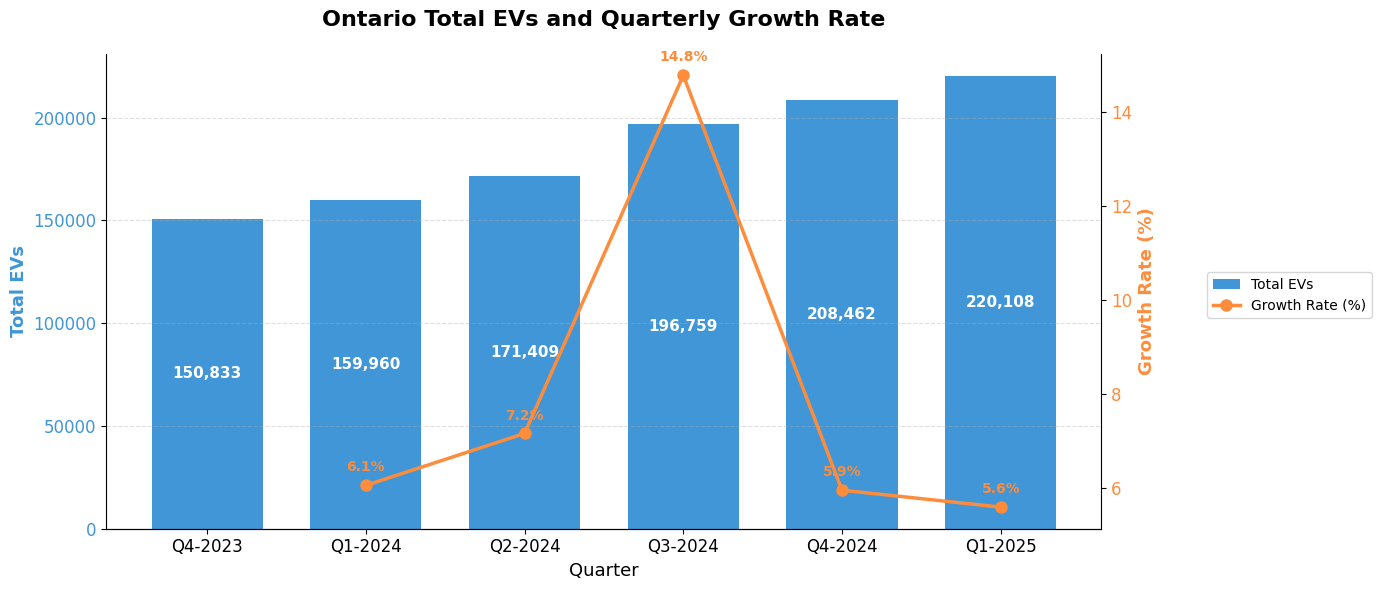

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def quarter_to_date(q):
    q_num, year = q.split('-')
    quarter = int(q_num[1])
    year = int(year)
    month = (quarter - 1) * 3 + 1
    return pd.Timestamp(year=year, month=month, day=1)

quarterly_totals['date'] = quarterly_totals['Quarter'].map(quarter_to_date)
quarterly_totals_sorted = quarterly_totals.sort_values('date').reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Total EVs per quarter
bars = ax1.bar(
    quarterly_totals_sorted['Quarter'],
    quarterly_totals_sorted['TotalEV'],
    color='#4096d6',
    width=0.7,
    label='Total EVs'
)

# Add bar labels (Total EVs)
ax1.bar_label(
    bars,
    labels=[f"{int(val):,}" for val in quarterly_totals_sorted['TotalEV']],
    label_type='center',
    color='white',
    fontsize=11,
    fontweight='bold'
)

ax1.set_xlabel('Quarter', fontsize=13)
ax1.set_ylabel('Total EVs', color='#4096d6', fontsize=13, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#4096d6', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.set_title('Ontario Total EVs and Quarterly Growth Rate', fontsize=16, fontweight='bold', pad=20)
ax1.grid(axis='y', linestyle='--', alpha=0.4)

# Secondary axis for Growth Rate (%)
ax2 = ax1.twinx()
line, = ax2.plot(
    quarterly_totals_sorted['Quarter'],
    quarterly_totals_sorted['GrowthRate'],
    color='#fd8d3c',
    marker='o',
    markersize=8,
    linewidth=2.5,
    label='Growth Rate (%)'
)

ax2.set_ylabel('Growth Rate (%)', color='#fd8d3c', fontsize=13, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#fd8d3c', labelsize=12)

# Annotate growth rate points
for idx, (x, y) in enumerate(zip(quarterly_totals_sorted['Quarter'], quarterly_totals_sorted['GrowthRate'])):
    if pd.notna(y):
        ax2.annotate(f"{y:.1f}%", xy=(x, y), xytext=(0, 10), textcoords='offset points',
                     ha='center', color='#fd8d3c', fontsize=10, fontweight='bold')

# Remove frame lines for a cleaner look
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Unified legend outside the plot
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = [line], [line.get_label()]
fig.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    borderaxespad=0.
)

plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0, 0.98, 1])

# Save high-res image
file_path = '/content/drive/My Drive/DS3_Machine Learning_Group 4/Figures/ontario_ev_growth_rate_plot.png'
fig.savefig(file_path, dpi=300, bbox_inches='tight')

plt.show()

BEV/PHEV ratios

In [ ]:
# Group by Quarter and sum BEV and PHEV
bev_phev_quarterly = df_ontario.groupby('Quarter')[['BEV', 'PHEV']].sum()

# Calculate the BEV/PHEV ratio
bev_phev_quarterly['BEV_PHEV_Ratio'] = bev_phev_quarterly['BEV'] / bev_phev_quarterly['PHEV']

print(bev_phev_quarterly[['BEV', 'PHEV', 'BEV_PHEV_Ratio']])

              BEV     PHEV  BEV_PHEV_Ratio
Quarter                                   
Q1-2024  117660.0  42300.0        2.781560
Q1-2025  160070.0  60038.0        2.666145
Q2-2024  125692.0  45717.0        2.749349
Q3-2024  143685.0  53074.0        2.707258
Q4-2023  110893.0  39940.0        2.776490
Q4-2024  151787.0  56675.0        2.678200


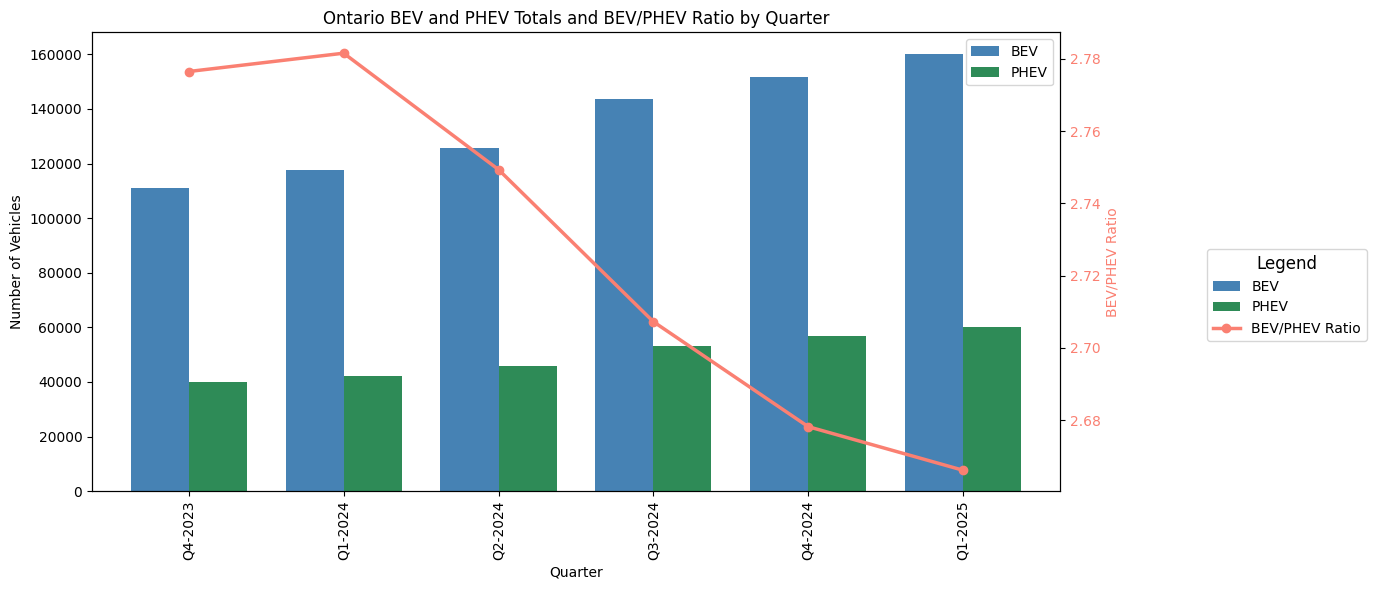

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to convert 'Qx-yyyy' to datetime for sorting
def quarter_to_date(q):
    q_num, year = q.split('-')
    return pd.Timestamp(year=int(year), month=(int(q_num[1])-1)*3 + 1, day=1)

# Convert and sort DataFrame by quarter
bev_phev_quarterly['date'] = bev_phev_quarterly.index.map(quarter_to_date)
bev_phev_quarterly_sorted = bev_phev_quarterly.sort_values('date').drop(columns='date')

# Start figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot: BEV and PHEV
colors = ['steelblue', 'seagreen']
bev_phev_quarterly_sorted[['BEV', 'PHEV']].plot(
    kind='bar', ax=ax1, color=colors, width=0.75
)
ax1.set_xlabel("Quarter")
ax1.set_ylabel("Number of Vehicles")
ax1.set_title("Ontario BEV and PHEV Totals and BEV/PHEV Ratio by Quarter")

# Create twin axis and line plot
ax2 = ax1.twinx()
line = ax2.plot(
    bev_phev_quarterly_sorted.index,
    bev_phev_quarterly_sorted['BEV_PHEV_Ratio'],
    color='salmon',
    marker='o',
    linewidth=2.5,
    label='BEV/PHEV Ratio'
)[0]
ax2.set_ylabel("BEV/PHEV Ratio", color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

# Combine legends from both axes
bars_legend = ax1.get_legend_handles_labels()
line_legend = ([line], [line.get_label()])
handles = bars_legend[0] + line_legend[0]
labels = bars_legend[1] + line_legend[1]

# Improve layout of combined legend
fig.legend(
    handles, labels,
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    borderaxespad=0,
    title='Legend',
    fontsize='medium',
    title_fontsize='large'
)

# Adjust layout for space and export
plt.tight_layout(rect=[0, 0, 0.95, 1])  # reserve space for side legend

# Save figure
file_path = '/content/drive/My Drive/DS3_Machine Learning_Group 4/Figures/BEV_PHEV_ratio_plot.png'
fig.savefig(file_path, bbox_inches='tight')

plt.show()


In [ ]:
quarter_order = {q: i for i, q in enumerate(quarters)}
quarterly_totals['QuarterOrder'] = quarterly_totals['Quarter'].map(quarter_order)
quarterly_totals = quarterly_totals.sort_values('QuarterOrder')

# Calculate rolling average (window=2)
quarterly_totals['RollingAvg_2'] = quarterly_totals['TotalEV'].rolling(window=2).mean()

# Calculate rolling average (window=3)
quarterly_totals['RollingAvg_3'] = quarterly_totals['TotalEV'].rolling(window=3).mean()

print(quarterly_totals[['Quarter', 'TotalEV', 'RollingAvg_2', 'RollingAvg_3']])

   Quarter  TotalEV  RollingAvg_2   RollingAvg_3
4  Q4-2023   150833           NaN            NaN
0  Q1-2024   159960      155396.5            NaN
2  Q2-2024   171409      165684.5  160734.000000
3  Q3-2024   196759      184084.0  176042.666667
5  Q4-2024   208462      202610.5  192210.000000
1  Q1-2025   220108      214285.0  208443.000000


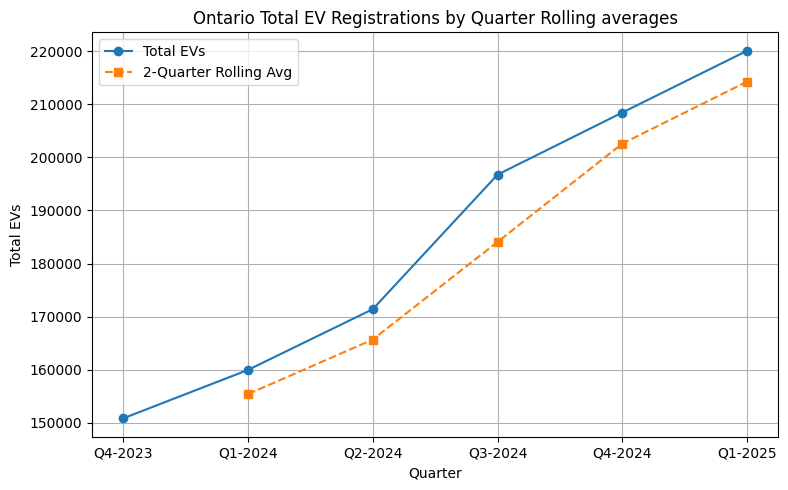

In [ ]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(quarterly_totals['Quarter'], quarterly_totals['TotalEV'], marker='o', label='Total EVs')
plt.plot(quarterly_totals['Quarter'], quarterly_totals['RollingAvg_2'], marker='s', linestyle='--', label='2-Quarter Rolling Avg')
plt.title('Ontario Total EV Registrations by Quarter Rolling averages')
plt.xlabel('Quarter')
plt.ylabel('Total EVs')
plt.legend()
plt.grid(True)
plt.tight_layout()

file_path = '/content/drive/My Drive/DS3_Machine Learning_Group 4/Figures/2-Quarter Rolling Avg.png'
fig.savefig(file_path, bbox_inches='tight')

plt.show()

/tmp/ipython-input-24-2001074458.py:44: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-24-2001074458.py:44: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-24-2001074458.py:49: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, bbox_inches='tight')
/tmp/ipython-input-24-2001074458.py:49: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128

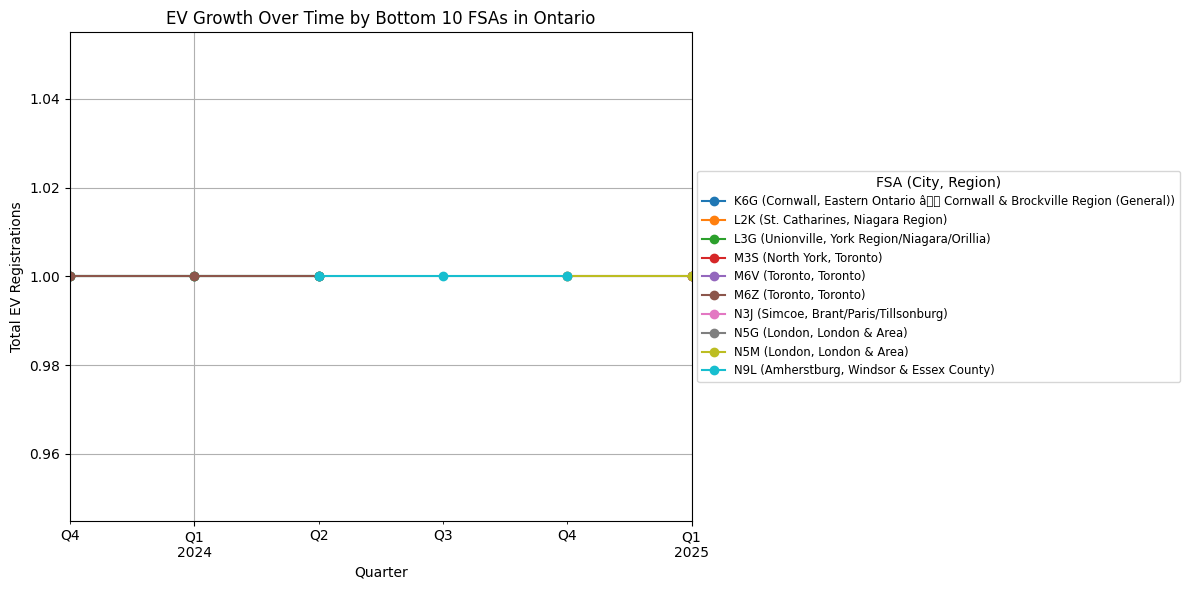

In [ ]:
# Get bottom 10 FSAs by total EV count
bottom_fsas = (
    df_ontario.groupby('FSA')['TotalEV']
    .sum()
    .sort_values(ascending=True)
    .head(10)
    .index
)

# Filter for bottom FSAs
df_bottom = df_ontario[df_ontario['FSA'].isin(bottom_fsas)]

# Create pivot table: Quarter vs FSA columns
pivot = df_bottom.pivot_table(index='Quarter', columns='FSA', values='TotalEV', aggfunc='sum')

# Convert 'Quarter' from 'Q1-2024' -> '2024Q1' (PeriodIndex, so sort plots chronologically)
pivot.index = pivot.index.to_series().str.replace(r'Q(\d)-(\d{4})', r'\2Q\1', regex=True)
pivot.index = pd.PeriodIndex(pivot.index, freq='Q')
pivot = pivot.sort_index()

# Load FSA coordinates with city and region
file_path = '/content/drive/My Drive/DS3_Machine Learning_Group 4/Data/ontario_fsa_coordinates_with_city_region.csv'
fsa_info_df = pd.read_csv(file_path, encoding='latin-1')
fsa_info_df = fsa_info_df.set_index('ï»¿FSA')

# Build enhanced legend labels: FSA (City, Region)
legend_labels = [
    f"{fsa} ({fsa_info_df.loc[fsa, 'City']}, {fsa_info_df.loc[fsa, 'Region']})"
    if fsa in fsa_info_df.index else fsa
    for fsa in pivot.columns
]

# Plot EV growth
fig, ax = plt.subplots(figsize=(12, 6))
pivot.plot(marker='o', ax=ax)

plt.title('EV Growth Over Time by Bottom 10 FSAs in Ontario')
plt.xlabel('Quarter')
plt.ylabel('Total EV Registrations')
plt.grid(True)

# Enhanced Legend
plt.legend(legend_labels, title='FSA (City, Region)', loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small')
plt.tight_layout()

# Save figure
file_path = '/content/drive/My Drive/DS3_Machine Learning_Group 4/Figures/Bottom10_FSA.png'
# file_path = 'Bottom10_FSA.png'
fig.savefig(file_path, bbox_inches='tight')

plt.show()

/tmp/ipython-input-25-1451833336.py:39: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-25-1451833336.py:39: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-25-1451833336.py:44: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, bbox_inches='tight')
/tmp/ipython-input-25-1451833336.py:44: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  fig.savefig(file_path, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128

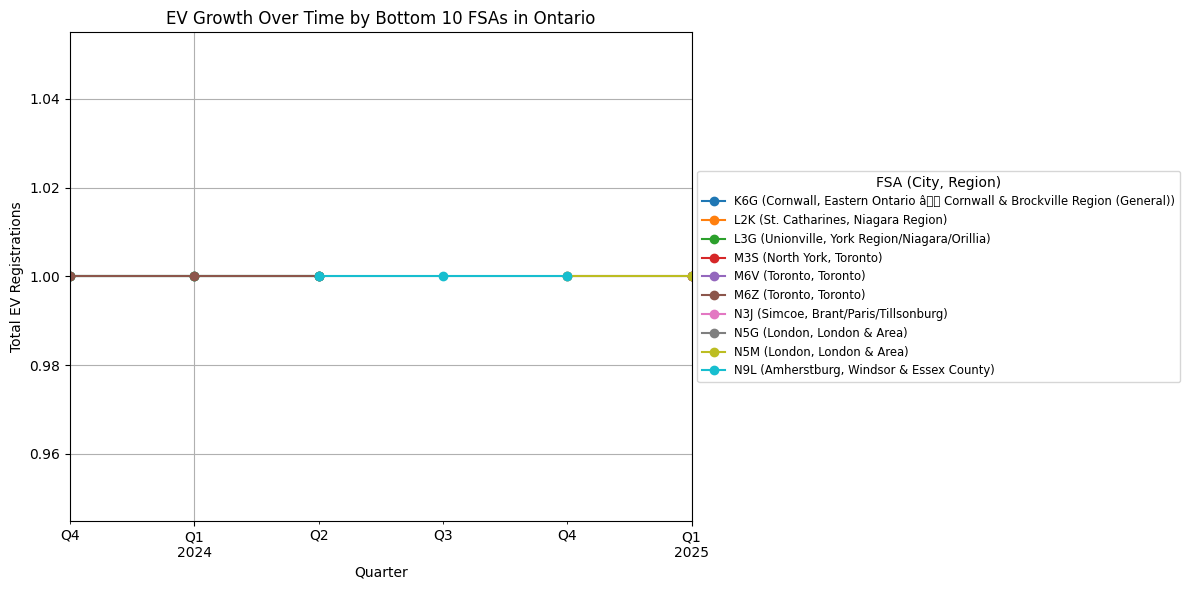

In [ ]:
# Get bottom 10 FSAs by total EV count
bottom_fsas = (
    df_ontario.groupby('FSA')['TotalEV']
    .sum()
    .sort_values(ascending=True)
    .head(10)
    .index
)

# Filter for bottom FSAs
df_bottom = df_ontario[df_ontario['FSA'].isin(bottom_fsas)]

# Create pivot table: Quarter vs FSA columns
pivot = df_bottom.pivot_table(index='Quarter', columns='FSA', values='TotalEV', aggfunc='sum')

# Convert 'Quarter' from 'Q1-2024' -> '2024Q1' (PeriodIndex, so sort plots chronologically)
pivot.index = pivot.index.to_series().str.replace(r'Q(\d)-(\d{4})', r'\2Q\1', regex=True)
pivot.index = pd.PeriodIndex(pivot.index, freq='Q')
pivot = pivot.sort_index()

# Build enhanced legend labels: FSA (City, Region)
legend_labels = [
    f"{fsa} ({fsa_info_df.loc[fsa, 'City']}, {fsa_info_df.loc[fsa, 'Region']})"
    if fsa in fsa_info_df.index else fsa
    for fsa in pivot.columns
]

# Plot EV growth
fig, ax = plt.subplots(figsize=(12, 6))
pivot.plot(marker='o', ax=ax)

plt.title('EV Growth Over Time by Bottom 10 FSAs in Ontario')
plt.xlabel('Quarter')
plt.ylabel('Total EV Registrations')
plt.grid(True)

# Enhanced Legend
plt.legend(legend_labels, title='FSA (City, Region)', loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small')
plt.tight_layout()

# Save figure
# file_path = '/content/drive/My Drive/DS3_Machine Learning_Group 4/Figures/Bottom10_FSA.png'
file_path = 'Bottom10_FSA.png'
fig.savefig(file_path, bbox_inches='tight')

plt.show()


In [ ]:
print(fsa_info_df.columns.tolist())

['City', 'Region', 'Latitude', 'Longitude']


In [ ]:
!pip install contextily

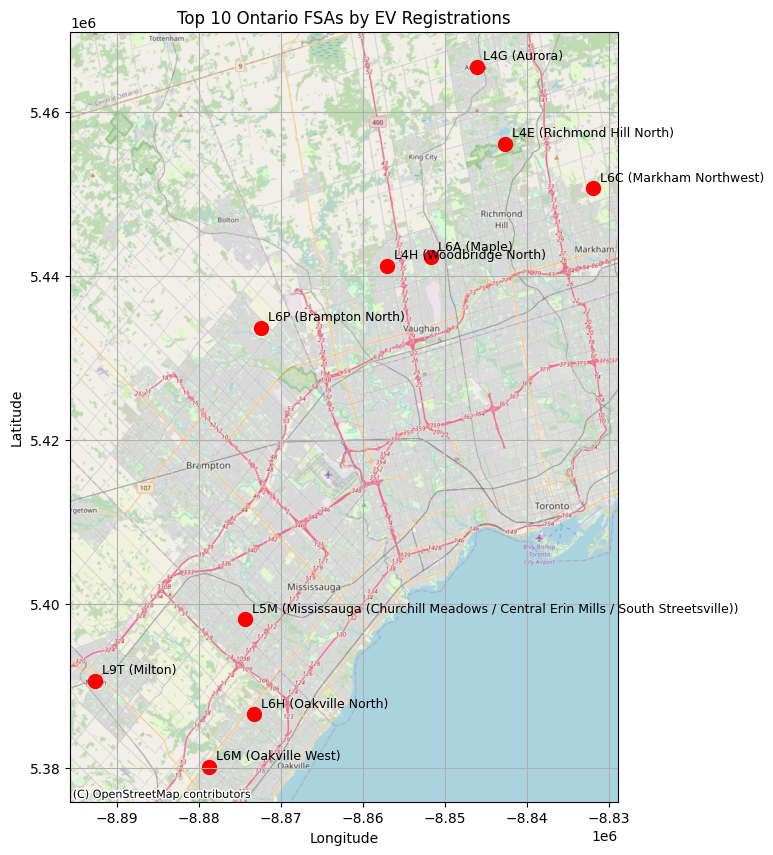

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx

# Install contextily if not already installed
try:
    import contextily as cx
except ImportError:
    !pip install contextily
    import contextily as cx

# Calculate top 10 FSAs
top_fsas = (
    df_ontario.groupby('FSA')['TotalEV']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Load FSA coordinates with city and region
file_path = '/content/drive/My Drive/DS3_Machine Learning_Group 4/Data/ontario_fsa_coordinates_with_city_region.csv'
fsa_coords = pd.read_csv(file_path)

top10_fsas = top_fsas[:10] if len(top_fsas) > 10 else top_fsas

# Filter coordinates for the top 10 FSAs
fsa_map = fsa_coords[fsa_coords['FSA'].isin(top10_fsas)]

# Create GeoDataFrame with Point geometry
gdf = gpd.GeoDataFrame(
    fsa_map,
    geometry=gpd.points_from_xy(fsa_map['Longitude'], fsa_map['Latitude']),
    crs='EPSG:4326'
)

# Project to Web Mercator for contextily
gdf = gdf.to_crs(epsg=3857)

# Plot map
fig, ax = plt.subplots(figsize=(8, 10))
gdf.plot(ax=ax, color='red', markersize=100)

# Add basemap
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

# Annotate FSA codes and cities
for idx, row in gdf.iterrows():
    ax.annotate(f"{row['FSA']} ({row['City']})", (row.geometry.x, row.geometry.y),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.title('Top 10 Ontario FSAs by EV Registrations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

file_path = '/content/drive/My Drive/DS3_Machine Learning_Group 4/Figures/Top10_map.png'
fig.savefig(file_path, bbox_inches='tight')

plt.show()

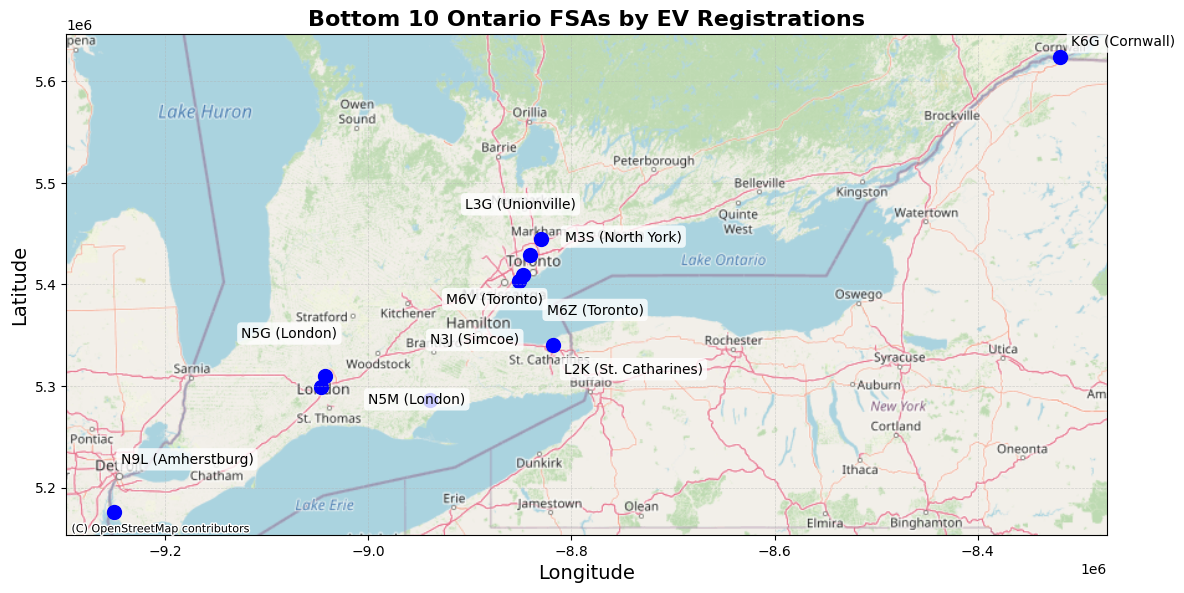

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx

# Calculate bottom 10 FSAs by EV registrations
bottom_fsas = (
    df_ontario.groupby('FSA')['TotalEV']
    .sum()
    .sort_values(ascending=True)
    .head(10)
    .index
)
bottom10_fsas = bottom_fsas[:10] if len(bottom_fsas) > 10 else bottom_fsas
fsa_map_bottom = fsa_coords[fsa_coords['FSA'].isin(bottom10_fsas)]

# Create GeoDataFrame
bottom_gdf = gpd.GeoDataFrame(
    fsa_map_bottom,
    geometry=gpd.points_from_xy(fsa_map_bottom['Longitude'], fsa_map_bottom['Latitude']),
    crs='EPSG:4326'
)
bottom_gdf = bottom_gdf.to_crs(epsg=3857)

# Plot map
fig, ax = plt.subplots(figsize=(12, 10))
bottom_gdf.plot(ax=ax, color='blue', markersize=100)

# Add basemap
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

# Annotate FSA codes and cities with enhanced styling (only do this once)
offsets = [
    (8, 8), (8, -20), (-55, 22), (25, 10),
    (-55, -20), (20, -24), (0, 40), (-60, 28),
    (34, -12), (5, 35)
]

for i, (idx, row) in enumerate(bottom_gdf.iterrows()):
    dx, dy = offsets[i % len(offsets)]
    ax.annotate(
        f"{row['FSA']} ({row['City']})",
        (row.geometry.x, row.geometry.y),
        xytext=(dx, dy),
        textcoords='offset points',
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8, lw=0)
    )

plt.title('Bottom 10 Ontario FSAs by EV Registrations', fontsize=16, weight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
file_path_bottom = '/content/drive/My Drive/DS3_Machine Learning_Group 4/Figures/Bottom10_map.png'
fig.savefig(file_path_bottom, bbox_inches='tight', dpi=150)
plt.show()


In [ ]:
!pip install geopandas contextily folium

In [ ]:
!pip install geopandas

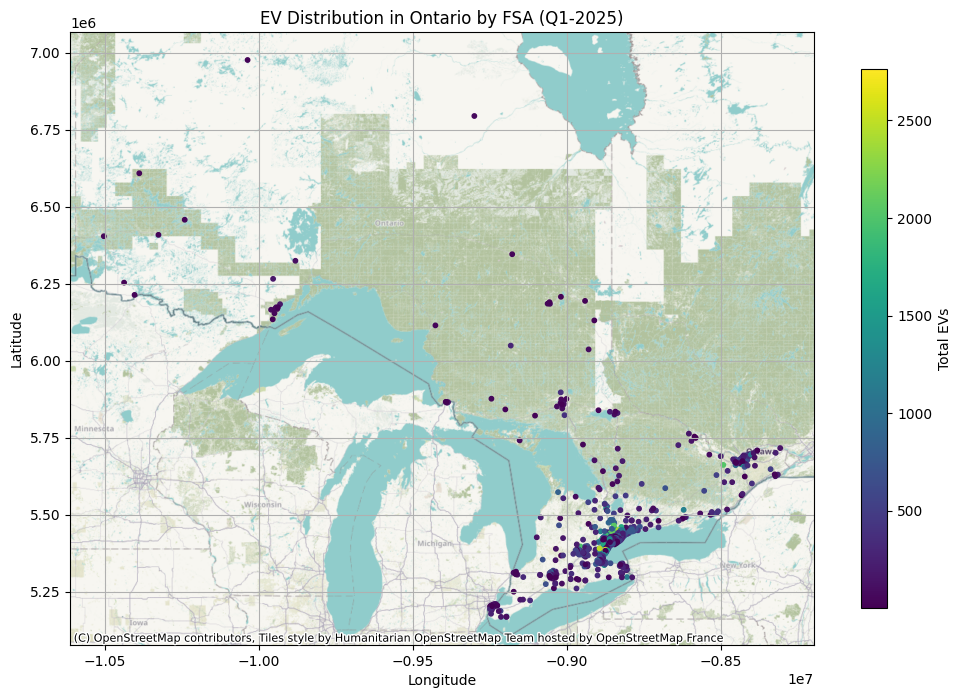

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import folium

# Load files
fsa_coords = pd.read_csv('/content/drive/My Drive/DS3_Machine Learning_Group 4/Data/ontario_fsa_coordinates_with_city_region.csv')
ev_counts = pd.read_csv('/content/drive/My Drive/DS3_Machine Learning_Group 4/Data/Q2-2023 - Q1-2025.csv')

# Filter latest quarter only to avoid duplication
latest_ev = ev_counts[ev_counts['Quarter'] == 'Q1-2025']
latest_ev = latest_ev[['FSA', 'TotalEV']]  # Keep only relevant columns

# Merge EV count with geocoordinates
merged = pd.merge(fsa_coords, latest_ev, on='FSA', how='inner')

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    merged,
    geometry=gpd.points_from_xy(merged['Longitude'], merged['Latitude']),
    crs='EPSG:4326'
)

# ➤ Plot using GeoPandas and Contextily (static map)
gdf_webmerc = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 14))
gdf_webmerc.plot(ax=ax, column='TotalEV', cmap='viridis',
                 legend=True, markersize=10,
                 legend_kwds={'label': "Total EVs", 'shrink': 0.5})
cx.add_basemap(ax, crs=gdf_webmerc.crs)
plt.title('EV Distribution in Ontario by FSA (Q1-2025)')
plt.grid(True)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Save the plot
fig.savefig('/content/drive/My Drive/DS3_Machine Learning_Group 4/Figures/ev_distribution_q1_2025.png', bbox_inches='tight')
plt.show()

# ➤ Create Interactive Map using Folium
m = folium.Map(location=[gdf['Latitude'].mean(), gdf['Longitude'].mean()], zoom_start=6)

# Add EV markers with scaling
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=max(row['TotalEV'] / 200, 2),  # Adjust scale
        color='blue',
        fill=True,
        popup=f"FSA: {row['FSA']}<br>EVs: {row['TotalEV']}"
    ).add_to(m)

# Save interactive map
m.save('/content/drive/My Drive/DS3_Machine Learning_Group 4/Figures/ev_map_q1_2025.html')


In [ ]:
import pandas as pd
import folium
import json

# Load EV and FSA location data
fsa_coords = pd.read_csv('/content/drive/My Drive/DS3_Machine Learning_Group 4/Data/ontario_fsa_coordinates_with_city_region.csv')
ev_data = pd.read_csv('/content/drive/My Drive/DS3_Machine Learning_Group 4/Data/Q2-2023 - Q1-2025.csv')

# Filter for the latest available quarter
latest_quarter = 'Q1-2025'
ev_latest = ev_data[ev_data['Quarter'] == latest_quarter][['FSA', 'TotalEV']]

# Merge to get coordinates
merged_df = pd.merge(fsa_coords, ev_latest, on='FSA', how='inner')

# Initialize Folium map centered on Ontario
m = folium.Map(location=[merged_df['Latitude'].mean(), merged_df['Longitude'].mean()],
               zoom_start=7, tiles='cartodbpositron')

# --- Add Ontario boundary GeoJSON (optional baseline layer)
ontario_geojson_path = '/content/drive/My Drive/DS3_Machine Learning_Group 4/Data/ontario_boundary.geojson'
folium.GeoJson(
    data=json.load(open(ontario_geojson_path)),
    name='Ontario Boundary',
    style_function=lambda feature: {
        'fill': False,
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    }
).add_to(m)

# --- Add Golden Horseshoe GeoJSON boundary as a highlighted layer
golden_horseshoe_geojson_path = '/content/drive/My Drive/DS3_Machine Learning_Group 4/Data/Golden Horseshoe.geojson'

folium.GeoJson(
    data=json.load(open(golden_horseshoe_geojson_path)),
    name='Golden Horseshoe',
    style_function=lambda feature: {
        'fill': True,
        'fillColor': 'yellow',
        'color': 'gold',
        'weight': 3,
        'fillOpacity': 0.2,
    },
    highlight_function=lambda feat: {
        'weight':5, 'color':'orange'
    },
    tooltip='Golden Horseshoe'
).add_to(m)

# --- Add EV markers as before
for _, row in merged_df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=max(row['TotalEV'] / 200, 2),
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=folium.Popup(f"FSA: {row['FSA']}<br>Total EVs: {int(row['TotalEV'])}", parse_html=True)
    ).add_to(m)

# Add a layer control so users can toggle layers
folium.LayerControl(collapsed=False).add_to(m)

# Save to HTML
m.save('/content/drive/My Drive/DS3_Machine Learning_Group 4/Figures/ev_golden_horseshoe_q1_2025.html')


Review/Refer to the HTML file under Figures folder for a better visual experience.


**Clustering Analysis**

This script performs a K-Means clustering analysis to segment
Ontario's Forward Sortation Areas (FSAs) based on EV adoption
patterns from Q2 2023 to Q1 2025.

In [ ]:
# Data Cleaning: Fill missing BEV/PHEV values with 0.
df['BEV'] = df['BEV'].fillna(0)
df['PHEV'] = df['PHEV'].fillna(0)

# Ensure data types are correct for calculations.
df['BEV'] = df['BEV'].astype(int)
df['PHEV'] = df['PHEV'].astype(int)
df['TotalEV'] = df['TotalEV'].astype(int)

# --- Feature 1: Adoption Level (Latest Quarter) ---
latest_quarter_df = df[df['Quarter'] == 'Q1-2025']
fsa_features = latest_quarter_df[['FSA', 'TotalEV']].rename(columns={'TotalEV': 'AdoptionLevel_Q1_2025'})

# --- Feature 2: Growth Rate (Q2 2023 to Q1 2025) ---
start_quarter_df = df[df['Quarter'] == 'Q2-2023']
end_quarter_df = df[df['Quarter'] == 'Q1-2025']
growth_df = pd.merge(
    start_quarter_df[['FSA', 'TotalEV']],
    end_quarter_df[['FSA', 'TotalEV']],
    on='FSA',
    suffixes=('_start', '_end')
)
growth_df['GrowthRate'] = ((growth_df['TotalEV_end'] - growth_df['TotalEV_start']) / growth_df['TotalEV_start'])
growth_df.replace([np.inf, -np.inf], np.nan, inplace=True)
growth_df['GrowthRate'] = growth_df['GrowthRate'].fillna(0)
fsa_features = pd.merge(fsa_features, growth_df[['FSA', 'GrowthRate']], on='FSA', how='left')

# --- Feature 3: BEV Preference (Average BEV Share) ---
df['BEV_Share'] = df.apply(lambda row: row['BEV'] / row['TotalEV'] if row['TotalEV'] > 0 else 0, axis=1)
bev_preference = df.groupby('FSA')['BEV_Share'].mean().reset_index().rename(columns={'BEV_Share': 'BEV_Preference'})
fsa_features = pd.merge(fsa_features, bev_preference, on='FSA', how='left')

# Final cleanup of the features DataFrame.
fsa_features.set_index('FSA', inplace=True)
fsa_features.fillna(0, inplace=True)

K-Means Clustering

In [ ]:

# Select and scale the features for clustering.
features_for_clustering = fsa_features[['AdoptionLevel_Q1_2025', 'GrowthRate', 'BEV_Preference']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

# Apply the K-Means algorithm.
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
fsa_features['Cluster'] = kmeans.fit_predict(scaled_features)


Cluster Interpretation and Analysis

In [ ]:
# Group by cluster to create a summary profile.
cluster_summary = fsa_features.groupby('Cluster').agg(
    {
        'AdoptionLevel_Q1_2025': 'mean',
        'GrowthRate': 'mean',
        'BEV_Preference': 'mean',
        'Cluster': 'count'
    }
).rename(columns={'Cluster': 'FSA_Count'})

# Format percentages for readability.
cluster_summary['GrowthRatePercent'] = (cluster_summary['GrowthRate'] * 100)
cluster_summary['BEV_PreferencePercent'] = (cluster_summary['BEV_Preference'] * 100)

# Sort for logical presentation.
cluster_summary = cluster_summary.sort_values(by='AdoptionLevel_Q1_2025', ascending=False)

print("--- Cluster Profiles Summary ---")
print(cluster_summary[['AdoptionLevel_Q1_2025', 'GrowthRatePercent', 'BEV_PreferencePercent', 'FSA_Count']].round(2))


--- Cluster Profiles Summary ---
         AdoptionLevel_Q1_2025  GrowthRatePercent  BEV_PreferencePercent  \
Cluster                                                                    
0                      1636.68              79.39                  78.11   
3                       364.52              88.00                  70.88   
1                        88.94              89.42                  46.01   
2                         8.67               2.39                  94.24   

         FSA_Count  
Cluster             
0               41  
3              394  
1              101  
2               46  


Visualization of Clusters


--- Visualizing the Clusters ---


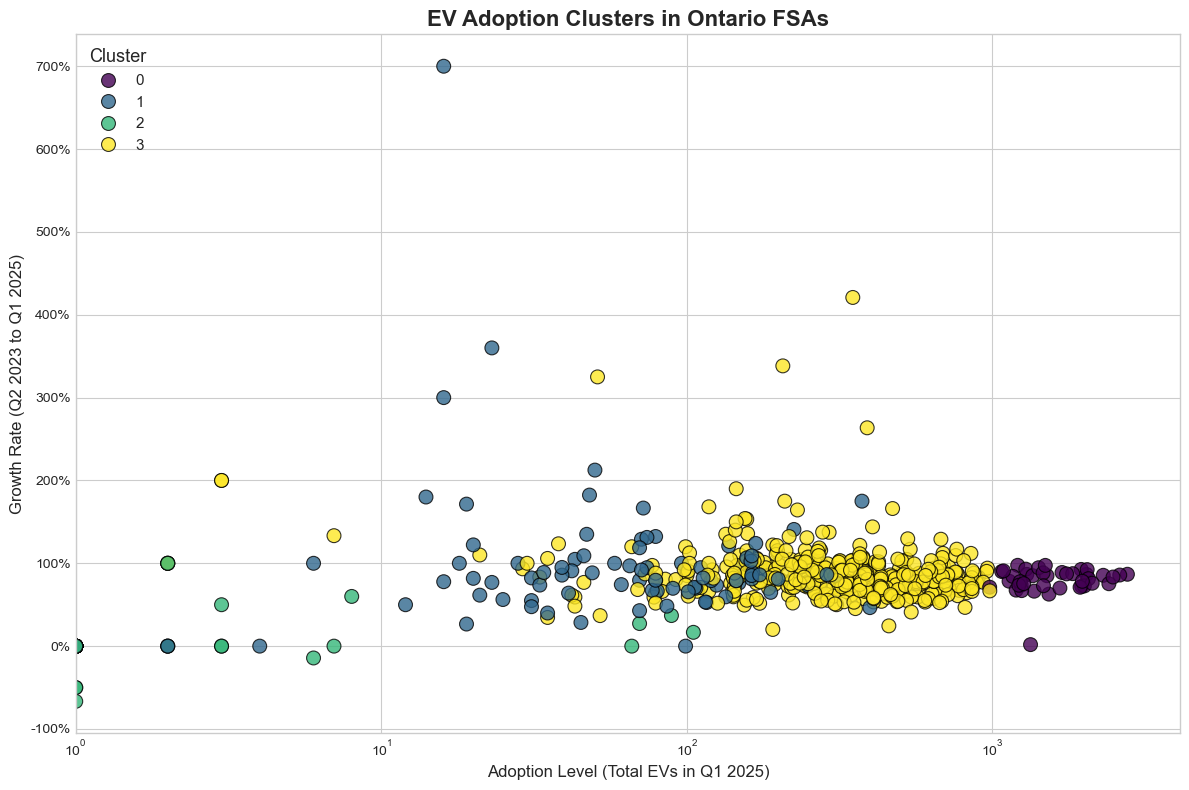

In [ ]:

print("\n--- Visualizing the Clusters ---")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Create a scatter plot of Adoption Level vs. Growth Rate.
scatter = sns.scatterplot(
    data=fsa_features,
    x='AdoptionLevel_Q1_2025',
    y='GrowthRate',
    hue='Cluster',
    palette='viridis',
    s=100,
    alpha=0.8,
    edgecolor='k',
    ax=ax
)

ax.set_title('EV Adoption Clusters in Ontario FSAs', fontsize=16, weight='bold')
ax.set_xlabel('Adoption Level (Total EVs in Q1 2025)', fontsize=12)
ax.set_ylabel('Growth Rate (Q2 2023 to Q1 2025)', fontsize=12)

# Format y-axis as percentages.
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Use a log scale for the x-axis to better visualize the wide range of adoption levels.
ax.set_xscale('log')
ax.set_xlim(left=1)

ax.legend(title='Cluster', title_fontsize='13', fontsize='11', loc='upper left')

plt.tight_layout()
plt.show()



--- Detailed Feature Distribution by Cluster ---


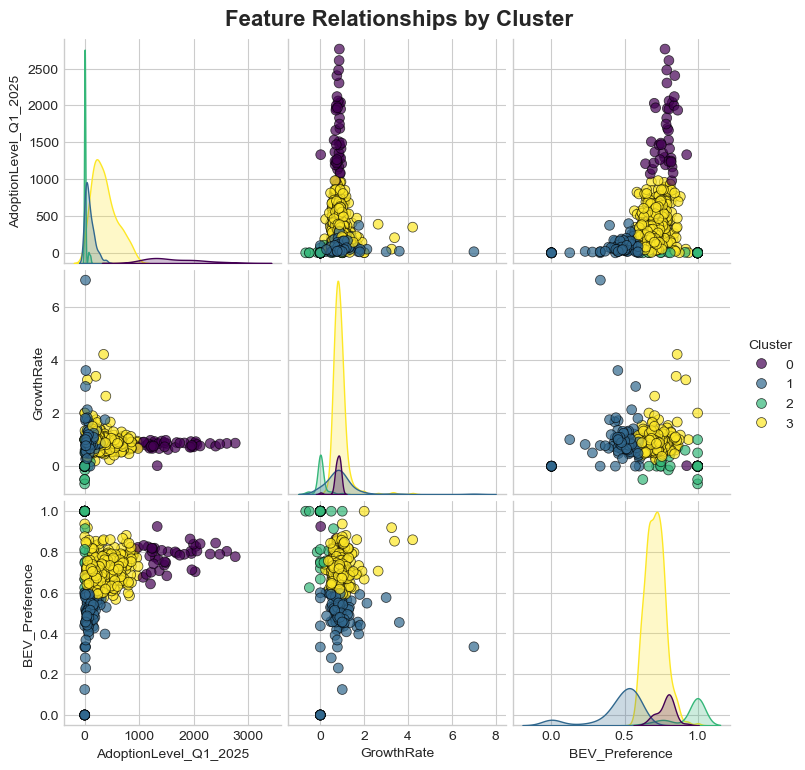

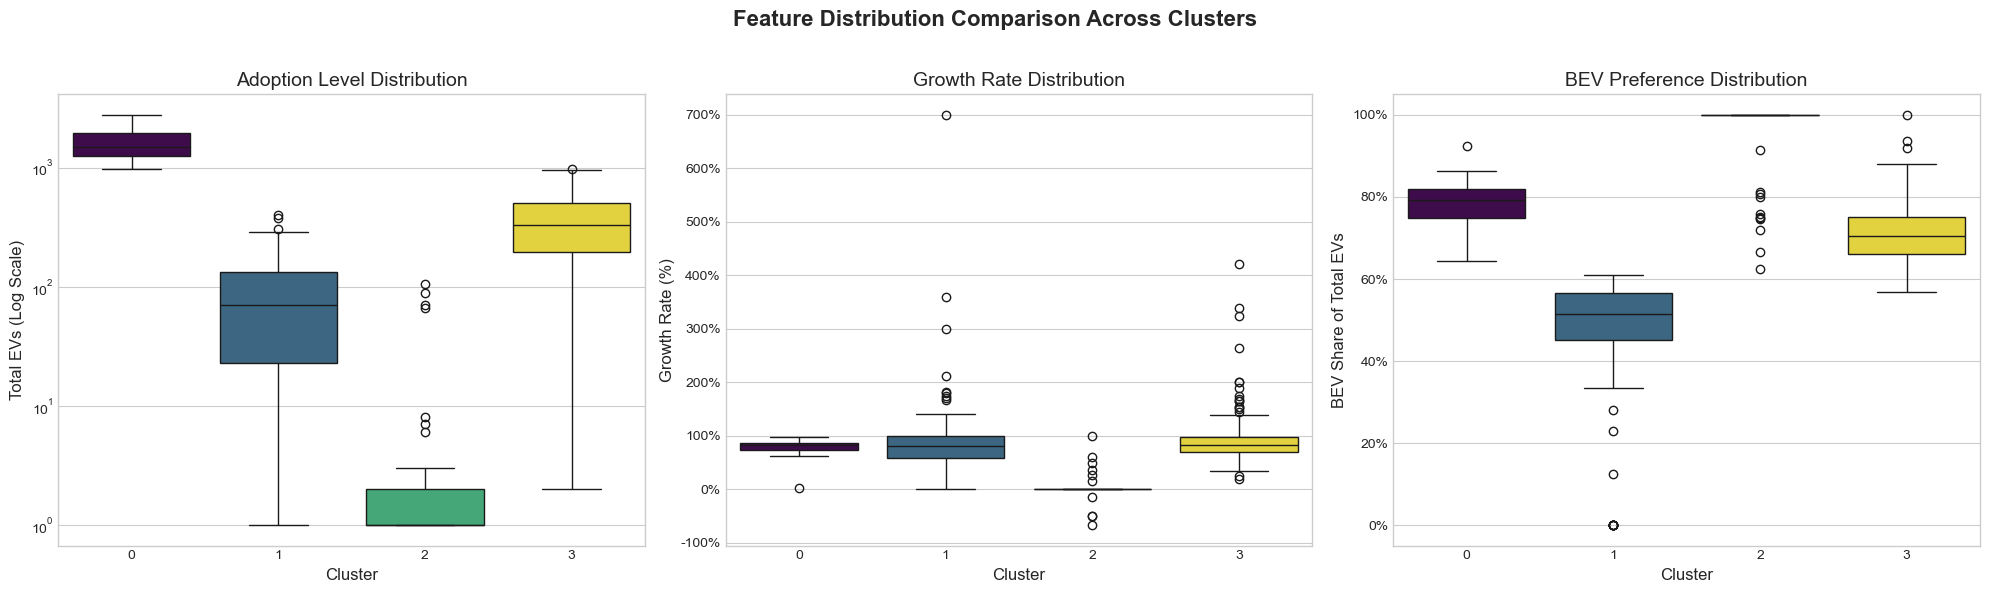


--- End of Analysis ---


In [ ]:
print("\n--- Detailed Feature Distribution by Cluster ---")

# --- Pair Plot Visualization ---
# A pair plot shows the relationship between every pair of features, colored by cluster.
pair_plot = sns.pairplot(
    fsa_features[['AdoptionLevel_Q1_2025', 'GrowthRate', 'BEV_Preference', 'Cluster']],
    hue='Cluster',
    palette='viridis',
    plot_kws={'alpha': 0.7, 's': 50, 'edgecolor': 'k'}
)
pair_plot.fig.suptitle('Feature Relationships by Cluster', y=1.02, fontsize=16, weight='bold')
plt.show()


# --- Box Plots for Each Feature ---
# Box plots are excellent for comparing the distribution of features across clusters.
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Feature Distribution Comparison Across Clusters', fontsize=16, weight='bold')

# Box plot for Adoption Level
sns.boxplot(data=fsa_features, x='Cluster', y='AdoptionLevel_Q1_2025', hue='Cluster', palette='viridis', ax=axes[0], legend=False)
axes[0].set_title('Adoption Level Distribution', fontsize=14)
axes[0].set_yscale('log') # Use log scale due to high variance
axes[0].set_xlabel('Cluster', fontsize=12)
axes[0].set_ylabel('Total EVs (Log Scale)', fontsize=12)

# Box plot for Growth Rate
sns.boxplot(data=fsa_features, x='Cluster', y='GrowthRate', hue='Cluster', palette='viridis', ax=axes[1], legend=False)
axes[1].set_title('Growth Rate Distribution', fontsize=14)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[1].set_xlabel('Cluster', fontsize=12)
axes[1].set_ylabel('Growth Rate (%)', fontsize=12)

# Box plot for BEV Preference
sns.boxplot(data=fsa_features, x='Cluster', y='BEV_Preference', hue='Cluster', palette='viridis', ax=axes[2], legend=False)
axes[2].set_title('BEV Preference Distribution', fontsize=14)
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[2].set_xlabel('Cluster', fontsize=12)
axes[2].set_ylabel('BEV Share of Total EVs', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


print("\n--- End of Analysis ---")

**Predictive Modeling and Optimization**

Models and eveluation to depict the validity of this approach in analyzing EV registration in Ontario between Q1 2024 to Q1 2025. Hyper parameters were fine tuned and cross-validation was performed.

In [ ]:
growth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FSA            554 non-null    object 
 1   TotalEV_start  554 non-null    int64  
 2   TotalEV_end    554 non-null    int64  
 3   GrowthRate     554 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 17.4+ KB


In [ ]:
df_features = fsa_features

In [ ]:
# Drop the _id column if it exists
if '_id' in df.columns:
    df.drop(columns=['_id'], inplace=True)

In [ ]:
# Sort by FSA and Quarter to prep for time-series based feature engineering
df.sort_values(['FSA', 'Quarter'], inplace=True)
df.head()

FSA   BEV  PHEV  TotalEV  Quarter  BEV_Share
1691  K0A  1021   418     1439  Q1-2024   0.709521
3997  K0A  1430   599     2029  Q1-2025   0.704781
0     K0A   752   336     1088  Q2-2023   0.691176
2264  K0A  1088   452     1540  Q2-2024   0.706494
558   K0A   835   360     1195  Q3-2023   0.698745

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4579 entries, 1691 to 3996
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FSA        4579 non-null   object 
 1   BEV        4579 non-null   int64  
 2   PHEV       4579 non-null   int64  
 3   TotalEV    4579 non-null   int64  
 4   Quarter    4579 non-null   object 
 5   BEV_Share  4579 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 250.4+ KB


In [ ]:
# Encode Quarter as ordinal integer
quarter_order = {q: i for i, q in enumerate(sorted(df['Quarter'].unique()))}
df['Quarter_Encoded'] = df['Quarter'].map(quarter_order)

In [ ]:
df.head()

FSA   BEV  PHEV  TotalEV  Quarter  BEV_Share  Quarter_Encoded
1691  K0A  1021   418     1439  Q1-2024   0.709521                0
3997  K0A  1430   599     2029  Q1-2025   0.704781                1
0     K0A   752   336     1088  Q2-2023   0.691176                2
2264  K0A  1088   452     1540  Q2-2024   0.706494                3
558   K0A   835   360     1195  Q3-2023   0.698745                4

In [ ]:
# Create lag features (previous quarter's EV count)
df['Prev_TotalEV'] = df.groupby('FSA')['TotalEV'].shift(1)
df['Prev_BEV'] = df.groupby('FSA')['BEV'].shift(1)
df['Prev_PHEV'] = df.groupby('FSA')['PHEV'].shift(1)
df['Prev_BEV_Share'] = df.groupby('FSA')['BEV_Share'].shift(1)

In [ ]:
df.head()

FSA   BEV  PHEV  TotalEV  Quarter  BEV_Share  Quarter_Encoded  \
1691  K0A  1021   418     1439  Q1-2024   0.709521                0   
3997  K0A  1430   599     2029  Q1-2025   0.704781                1   
0     K0A   752   336     1088  Q2-2023   0.691176                2   
2264  K0A  1088   452     1540  Q2-2024   0.706494                3   
558   K0A   835   360     1195  Q3-2023   0.698745                4   

      Prev_TotalEV  Prev_BEV  Prev_PHEV  Prev_BEV_Share  
1691           NaN       NaN        NaN             NaN  
3997        1439.0    1021.0      418.0        0.709521  
0           2029.0    1430.0      599.0        0.704781  
2264        1088.0     752.0      336.0        0.691176  
558         1540.0    1088.0      452.0        0.706494

In [ ]:
# Drop rows with NaNs created from shift
df_model = df.dropna().copy()

In [ ]:
# Define features and target
features = ['Quarter_Encoded', 'Prev_TotalEV', 'Prev_BEV', 'Prev_PHEV', 'Prev_BEV_Share']
target = 'TotalEV'

X = df_model[features]
y = df_model[target]

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#linear regression modelling
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluation
print("=== Linear Regression Evaluation ===")
print(f"RMSE: {mean_squared_error(y_test, y_pred_lr):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")
print(f"R²: {r2_score(y_test, y_pred_lr):.2f}")

=== Linear Regression Evaluation ===
RMSE: 24822.55
MAE: 103.99
R²: 0.79


In [ ]:
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Evaluation
print("\n=== Random Forest Evaluation ===")
print(f"Best Params: {grid_search.best_params_}")
print(f"RMSE: {mean_squared_error(y_test, y_pred_rf):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"R²: {r2_score(y_test, y_pred_rf):.2f}")


=== Random Forest Evaluation ===
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RMSE: 2899.40
MAE: 25.56
R²: 0.98


In [ ]:
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='r2')
print(f"Cross-validated R²: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

Cross-validated R²: 0.94 ± 0.05


In [ ]:
#function for evaluating the rf model
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Evaluation:")
    print(f"RMSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"R²: {r2_score(y_true, y_pred):.4f}")

evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)


Linear Regression Evaluation:
RMSE: 24822.55
MAE: 103.99
R²: 0.7949

Random Forest Evaluation:
RMSE: 2899.40
MAE: 25.56
R²: 0.9760


In [ ]:
#GridSearchCV for Random Forest
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
}

In [ ]:
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

evaluate_model("Tuned Random Forest", y_test, y_pred_best_rf)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/coolnoah/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/coolnoah/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/coolnoah/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/coolnoah/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currentl


Tuned Random Forest Evaluation:
RMSE: 2814.68
MAE: 25.31
R²: 0.9767


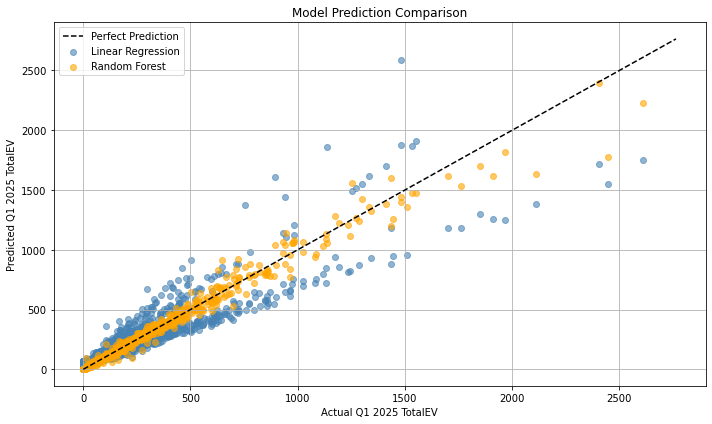

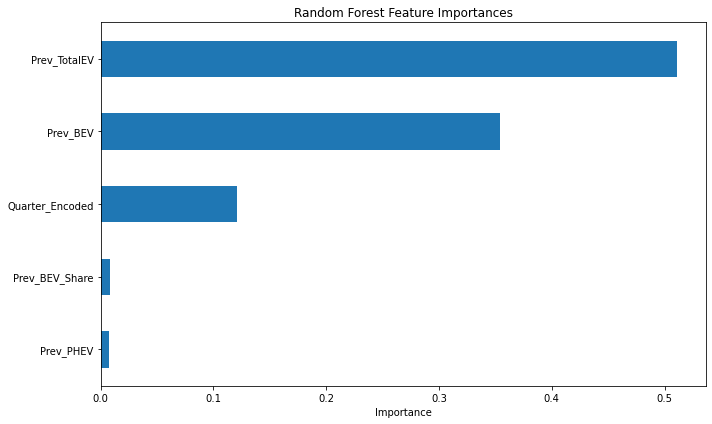

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.6, label='Linear Regression', color='steelblue')
plt.scatter(y_test, y_pred_rf, alpha=0.6, label='Random Forest', color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Perfect Prediction')
plt.xlabel('Actual Q1 2025 TotalEV')
plt.ylabel('Predicted Q1 2025 TotalEV')
plt.title('Model Prediction Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

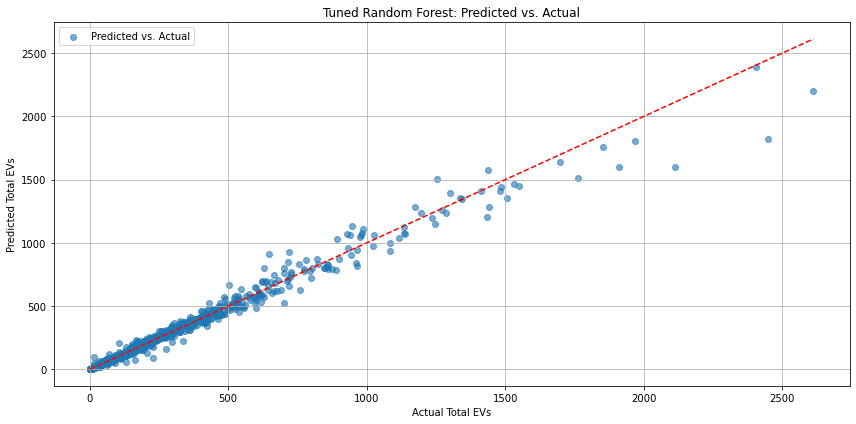

In [ ]:
# --- Visualize Predictions ---
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_best_rf, alpha=0.6, label='Predicted vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Total EVs')
plt.ylabel('Predicted Total EVs')
plt.title('Tuned Random Forest: Predicted vs. Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Testing Hypotheses**

In [ ]:
coord_df = pd.read_csv('/Users/coolnoah/group4data/ontario_fsa_coordinates_with_city_region.csv')

In [ ]:
coord_df.head()

FSA                                               City  \
0  K0A                  National Capital Region (Almonte)   
1  K0B      Prescott and Russell United Counties (Alfred)   
2  K0C  Stormont, Dundas and Glengarry United Counties...   
3  K0E  South Leeds and Grenville United Counties (Pre...   
4  K0G                     Rideau Lakes area (Kemptville)   

                 Region  Latitude  Longitude  
0  Eastern Ottawa Rural   45.2557   -76.2754  
1  Eastern Ottawa Rural   45.5029   -74.7479  
2  Eastern Ottawa Rural   45.1686   -74.8966  
3  Eastern Ottawa Rural   44.8734   -75.4416  
4  Eastern Ottawa Rural   45.0466   -76.4757

In [ ]:
# Prepare prediction input using most recent quarter
latest_quarter = df['Quarter_Encoded'].max()
latest_data = df[df['Quarter_Encoded'] == latest_quarter].copy()

# Use the lag features as current features
prediction_df = latest_data[['FSA', 'TotalEV', 'BEV', 'PHEV', 'BEV_Share']].copy()
prediction_df['Quarter_Encoded'] = latest_quarter + 1  # Predict for next quarter

# Rename to match model input
prediction_df.rename(columns={
    'TotalEV': 'Prev_TotalEV',
    'BEV': 'Prev_BEV',
    'PHEV': 'Prev_PHEV',
    'BEV_Share': 'Prev_BEV_Share'
}, inplace=True)

# Features for prediction
X_pred = prediction_df[['Quarter_Encoded', 'Prev_TotalEV', 'Prev_BEV', 'Prev_PHEV', 'Prev_BEV_Share']]
prediction_df['Predicted_TotalEV'] = best_rf.predict(X_pred)

In [ ]:
# Merge prediction results with coordinates
prediction_map_df = pd.merge(prediction_df, coord_df, on='FSA', how='left')

# Check if any FSAs didn't match
missing_coords = prediction_map_df[prediction_map_df['Latitude'].isna()]
if not missing_coords.empty:
    print("Missing coordinates for some FSAs:")
    print(missing_coords['FSA'].unique())

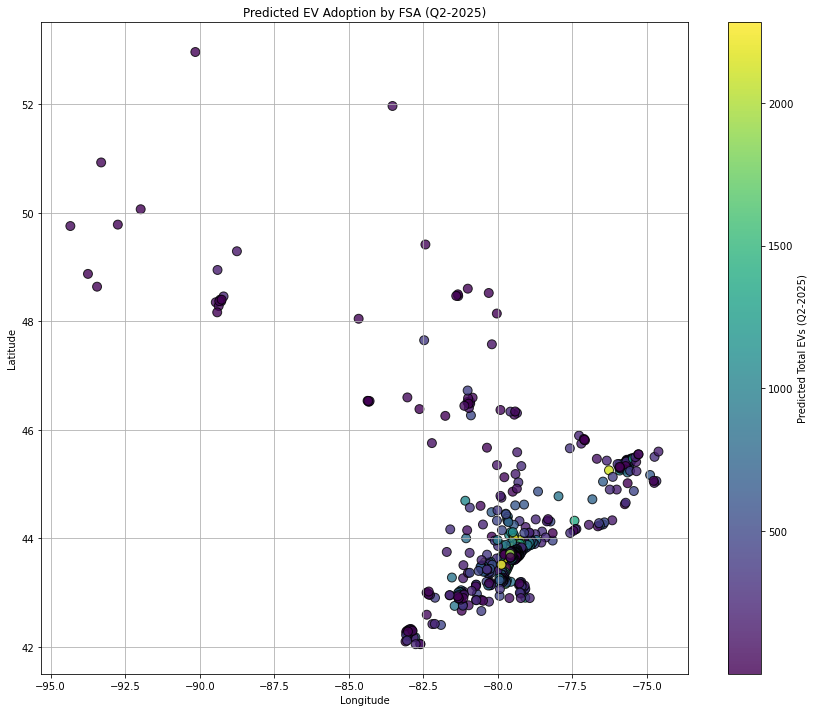

In [ ]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    prediction_map_df['Longitude'],
    prediction_map_df['Latitude'],
    c=prediction_map_df['Predicted_TotalEV'],
    cmap='viridis',
    s=80,
    edgecolor='k',
    alpha=0.8
)

plt.colorbar(scatter, label='Predicted Total EVs (Q2-2025)')
plt.title('Predicted EV Adoption by FSA (Q2-2025)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df.head()

FSA   BEV  PHEV  TotalEV  Quarter  BEV_Share  Quarter_Encoded  \
1691  K0A  1021   418     1439  Q1-2024   0.709521                0   
3997  K0A  1430   599     2029  Q1-2025   0.704781                1   
0     K0A   752   336     1088  Q2-2023   0.691176                2   
2264  K0A  1088   452     1540  Q2-2024   0.706494                3   
558   K0A   835   360     1195  Q3-2023   0.698745                4   

      Prev_TotalEV  Prev_BEV  Prev_PHEV  Prev_BEV_Share  
1691           NaN       NaN        NaN             NaN  
3997        1439.0    1021.0      418.0        0.709521  
0           2029.0    1430.0      599.0        0.704781  
2264        1088.0     752.0      336.0        0.691176  
558         1540.0    1088.0      452.0        0.706494

In [ ]:
prediction_df.head()

FSA  Prev_TotalEV  Prev_BEV  Prev_PHEV  Prev_BEV_Share  Quarter_Encoded  \
3418  K0A          1911      1346        565        0.704343                8   
3419  K0B           224       139         85        0.620536                8   
3420  K0C           475       293        182        0.616842                8   
3421  K0E           352       237        115        0.673295                8   
3422  K0G           506       352        154        0.695652                8   

      Predicted_TotalEV  
3418            2114.28  
3419             308.58  
3420             645.88  
3421             478.98  
3422             692.22